In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline

In [2]:
from os import listdir
from os.path import isfile, join
path = '../RetweetDataAOAS/retweet_data/'
root_tweet_names = [f for f in listdir(path) if isfile(join(path, f))]
num_root_tweets = len(root_tweet_names)

In [3]:
# Produces a dictionary of dataframes for each tweetfile, with initial 
# preprocessing
fields = ['RetweetCount', 'UserId', 'ScreenName', 'FollowerCount', 
          'DistanceFromRoot','Time', 'ParentScreenName', 'Text']
tweet_dfs = []
for i in range(num_root_tweets):
    tweet_df = pd.read_csv(path+root_tweet_names[i], sep="\t", header=None, 
                         quoting=csv.QUOTE_NONE, names=fields, encoding = "ISO-8859-1")
    
    tweet_df['Time'] = pd.to_datetime(tweet_df['Time'])

    screen_name_index = {}
    for index, row in tweet_df.iterrows():
        screen_name_index[row['ScreenName']] = index
    tweet_df['ParentDfIndex'] = tweet_df['ParentScreenName'].map(screen_name_index)
    
    tweet_dfs.append(tweet_df)

In [4]:
# Returns a dictionary of reaction times S_j^x keyed by user id
def generate_reaction_times(tweet_df):
    reaction_times = {}
    for index, row in tweet_df.iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_df.at[row['ParentDfIndex'],
                                                      'Time']
            reaction_times[row['UserId']] = reaction_time
    return reaction_times

In [5]:
# Returns a dictionary of M_j^x keyed by user id
def generate_number_of_follower_who_retweet(tweet_df):
    number_of_follower_who_retweet = {}
    for index, row in tweet_df.iterrows():
        if row['UserId'] not in number_of_follower_who_retweet:
            number_of_follower_who_retweet[row['UserId']] = 0
        parent_user_id = tweet_df.at[row['ParentDfIndex'], 'UserId']
        number_of_follower_who_retweet[parent_user_id] += 1
    return number_of_follower_who_retweet

In [55]:
log_s_j_x = []
for i in range(num_root_tweets):
    s_j_x = sorted(generate_reaction_times(tweet_dfs[i]).values())
    log_s_j_x.append([np.log(i.seconds) for i in s_j_x])
fake_logs = [[1 for i in range(num_root_tweets)] for j in range(5)]
print(np.mean(log_s_j_x[i]))

6.668617787


In [50]:
# Scratch pymc3 code
with pm.Model() as twitter_model:
    # global model parameters
    # Time-related hyperparameters
    alpha = pm.Normal('alpha', mu=0, sd=100)
    sigma_squared_delta = pm.InverseGamma('sigma_squared_delta', alpha=2, beta=2)
    log_a_tau = pm.Normal('log_a_tau', mu=0, sd=10)
    b_tau = pm.Gamma('b_tau', alpha=1, beta=.002)
    
    # Graph-related hyperparameters
    # sigma_squared_b = pm.InverseGamma('sigma_squared_b', alpha=0.5, beta=0.5, testval=10000)
    # beta_0 = pm.Normal('beta_0', mu=0, tau=1/sigma_squared_b)
    # beta_F = pm.Normal('beta_F', mu=0, tau=1/sigma_squared_b)
    # beta_d = pm.Normal('beta_d', mu=0, tau=1/sigma_squared_b)
    
    # log-normal model for reaction times, nonrecursive...
    a_tau = pm.math.exp(log_a_tau)
    for i in range(num_root_tweets):
        t_x = pm.InverseGamma('tau_x_squared_' + str(i), alpha=a_tau, beta=b_tau)
        a_x = pm.Normal('alpha_x_' + str(i), mu=alpha, tau=1/sigma_squared_delta)        
        l_x = pm.Normal('log_s_j_x_' + str(i), mu=a_x, tau=t_x**0.5, observed=log_s_j_x[i])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_x_51, tau_x_squared_51_log__, alpha_x_50, tau_x_squared_50_log__, alpha_x_49, tau_x_squared_49_log__, alpha_x_48, tau_x_squared_48_log__, alpha_x_47, tau_x_squared_47_log__, alpha_x_46, tau_x_squared_46_log__, alpha_x_45, tau_x_squared_45_log__, alpha_x_44, tau_x_squared_44_log__, alpha_x_43, tau_x_squared_43_log__, alpha_x_42, tau_x_squared_42_log__, alpha_x_41, tau_x_squared_41_log__, alpha_x_40, tau_x_squared_40_log__, alpha_x_39, tau_x_squared_39_log__, alpha_x_38, tau_x_squared_38_log__, alpha_x_37, tau_x_squared_37_log__, alpha_x_36, tau_x_squared_36_log__, alpha_x_35, tau_x_squared_35_log__, alpha_x_34, tau_x_squared_34_log__, alpha_x_33, tau_x_squared_33_log__, alpha_x_32, tau_x_squared_32_log__, alpha_x_31, tau_x_squared_31_log__, alpha_x_30, tau_x_squared_30_log__, alpha_x_29, tau_x_squared_29_log__, alpha_x_28, tau_x_squared_28_log__, alpha_x_27

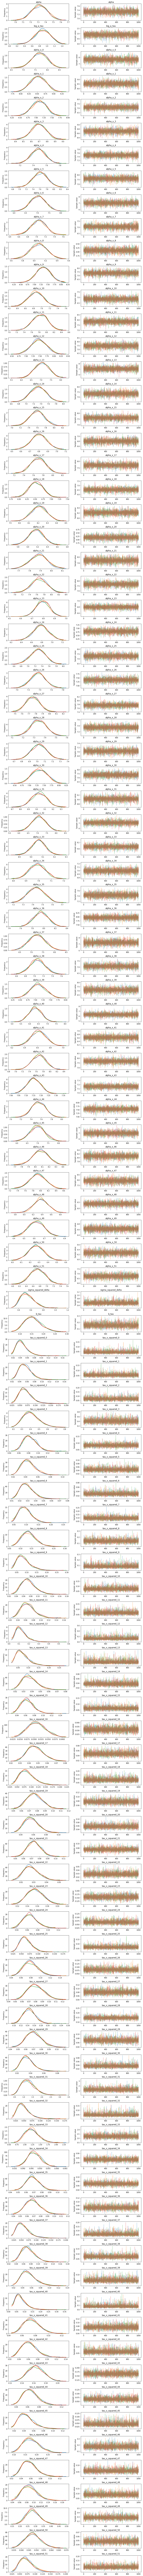

In [51]:
with twitter_model:
    trace = pm.sample(1000, tune=1000, cores=4)
    pm.traceplot(trace)

In [52]:
for RV in twitter_model.basic_RVs:
    print(RV.name, RV.logp(twitter_model.test_point))

alpha -5.524108719192764
sigma_squared_delta_log__ -0.9999999961906912
log_a_tau -3.2215236261987186
b_tau_log__ -1.0
tau_x_squared_0_log__ -1.3068528194400546
alpha_x_0 -1.2655121234846454
tau_x_squared_1_log__ -1.3068528194400546
alpha_x_1 -1.2655121234846454
tau_x_squared_2_log__ -1.3068528194400546
alpha_x_2 -1.2655121234846454
tau_x_squared_3_log__ -1.3068528194400546
alpha_x_3 -1.2655121234846454
tau_x_squared_4_log__ -1.3068528194400546
alpha_x_4 -1.2655121234846454
tau_x_squared_5_log__ -1.3068528194400546
alpha_x_5 -1.2655121234846454
tau_x_squared_6_log__ -1.3068528194400546
alpha_x_6 -1.2655121234846454
tau_x_squared_7_log__ -1.3068528194400546
alpha_x_7 -1.2655121234846454
tau_x_squared_8_log__ -1.3068528194400546
alpha_x_8 -1.2655121234846454
tau_x_squared_9_log__ -1.3068528194400546
alpha_x_9 -1.2655121234846454
tau_x_squared_10_log__ -1.3068528194400546
alpha_x_10 -1.2655121234846454
tau_x_squared_11_log__ -1.3068528194400546
alpha_x_11 -1.2655121234846454
tau_x_squared_